In [1]:
import numpy as np
import pandas as pd

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-21 11:08:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: 'course_lead_scoring.csv.1'

     0K .......... .......... .......... .......... .......... 63%  134K 0s
    50K .......... .......... ........                        100% 10.2M=0.4s

2025-10-21 11:08:50 (210 KB/s) - 'course_lead_scoring.csv.1' saved [80876/80876]



In [33]:
df = pd.read_csv('course_lead_scoring.csv.1')

In [34]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [35]:
list(df.columns)

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score',
 'converted']

In [36]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [37]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [39]:
categorical = list(df.columns[df.dtypes == 'object'])
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [40]:
numerical = list(df.columns[df.dtypes != 'object'])
numerical

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [41]:
df[categorical] = df[categorical].fillna('NA')
df[numerical]= df[numerical].fillna(0.0)

df[numerical].isnull().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [42]:
df[df.columns[df.dtypes== 'object']].nunique()

lead_source          6
industry             8
employment_status    5
location             8
dtype: int64

In [43]:
df.lead_source.value_counts()

lead_source
organic_search    282
social_media      278
paid_ads          264
referral          260
events            250
NA                128
Name: count, dtype: int64

In [44]:
df.industry.value_counts()

industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64

In [45]:
df.employment_status.value_counts()

employment_status
self_employed    352
student          348
unemployed       334
employed         328
NA               100
Name: count, dtype: int64

In [46]:
df.location.value_counts()

location
north_america    225
europe           216
middle_east      198
asia             195
south_america    192
africa           188
australia        185
NA                63
Name: count, dtype: int64

In [47]:
df.converted.value_counts()

converted
1    905
0    557
Name: count, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
y = df.converted

del df['converted']

df_train_val, df_test, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_train_val,y_train_val, test_size=0.25, random_state=1)

### 1. ROC AUC

In [50]:
from sklearn.metrics import roc_auc_score

In [51]:
numerical_columns = list(df.columns[df.dtypes != 'object'])
numerical_columns

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [52]:
for col in numerical_columns:
    score = roc_auc_score(y_train, df_train[col])
    print(f"Columns: {col:<10} AUC Score: {score} ")
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[col])
        print(f"Columns: {col:<10} New AUC Score: {score} ")

Columns: number_of_courses_viewed AUC Score: 0.7635680590007088 
Columns: annual_income AUC Score: 0.5519578313253012 
Columns: interaction_count AUC Score: 0.738270176293409 
Columns: lead_score AUC Score: 0.6144993577250176 


### 2. Training

In [53]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [54]:
train_dicts = df_train.to_dict(orient='records')
train_dicts[0]

{'lead_source': 'events',
 'industry': 'manufacturing',
 'number_of_courses_viewed': 2,
 'annual_income': 95543.0,
 'employment_status': 'unemployed',
 'location': 'europe',
 'interaction_count': 3,
 'lead_score': 0.78}

In [55]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)

X_train.shape

(876, 31)

In [56]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [57]:
model.fit(X_train, y_train)

model.score(X_train, y_train)

0.7340182648401826

In [58]:
X_val = dv.transform(df_val.to_dict(orient='records'))
X_val.shape

(293, 31)

In [59]:
model.score(X_val, y_val)

0.6996587030716723

In [60]:
y_pred = model.predict(X_val)

In [61]:
round(roc_auc_score(y_val, y_pred),3)

np.float64(0.648)

### 3. Precision and Recall

In [62]:
thresholds = np.linspace(0,1,101)

In [63]:
y_pred_proba = model.predict_proba(X_val)[:,1]

In [70]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred_proba >= t) & (y_val == 1)).sum()
    fp = ((y_pred_proba >= t) & (y_val == 0)).sum()
    fn = ((y_pred_proba < t) & (y_val == 1)).sum()
    tn = ((y_pred_proba < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [71]:
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,171,122,0,0
1,0.01,171,122,0,0
2,0.02,171,122,0,0
3,0.03,171,122,0,0
4,0.04,171,122,0,0


In [72]:
df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

In [73]:
df_scores.tail()

,threshold,tp,fp,fn,tn,precision,recall
96,0.96,3,0,168,122,1.0,0.017544
97,0.97,1,0,170,122,1.0,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000
100,1.00,0,0,171,122,NaN,0.000000


In [74]:
import matplotlib.pyplot as plt

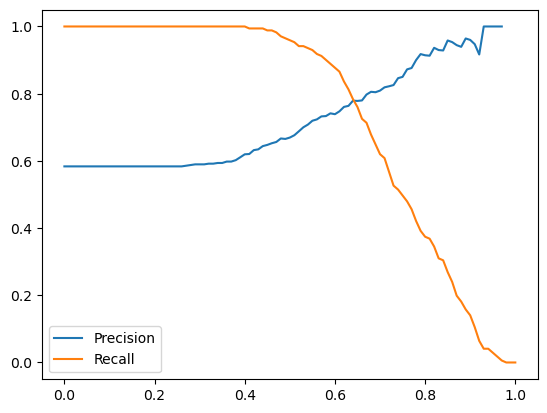

In [75]:
plt.plot(df_scores.threshold, df_scores.precision, label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, label='Recall')
plt.legend()
plt.show()

In [76]:
df_scores['f1-score'] = (2*df_scores['precision']*df_scores['recall']) / (df_scores['precision']+df_scores['recall'])

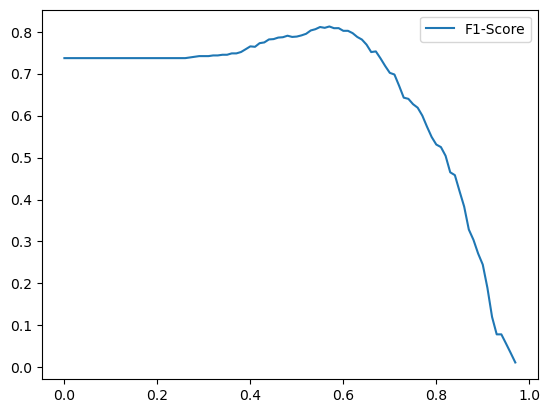

In [77]:
plt.plot(df_scores.threshold, df_scores['f1-score'], label='F1-Score')
plt.legend()
plt.show()

In [80]:
df_scores[df_scores['f1-score']==df_scores['f1-score'].max()]

,threshold,tp,fp,fn,tn,precision,recall,f1-score
57,0.57,156,57,15,65,0.732394,0.912281,0.8125


### 5. CV

In [81]:
from sklearn.model_selection import KFold

In [82]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [83]:
def train(df, y):
    cat = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df.to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [84]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_val):
    df_train = df_train_val.iloc[train_idx]
    y_train = y_train_val.iloc[train_idx].values

    df_val = df_train_val.iloc[val_idx]
    y_val = y_train_val.iloc[val_idx].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [85]:
aucs

[np.float64(0.8060745924216483),
 np.float64(0.8713738368910783),
 np.float64(0.7754320118852139),
 np.float64(0.8018368617683685),
 np.float64(0.8558272713202291)]

In [86]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.822 ± 0.036


### 6. Hyperparameter tuning

In [87]:
def train(df, y, C=1.0):
    cat = df.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [88]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_val):
        df_train = df_train_val.iloc[train_idx]
        df_val = df_train_val.iloc[val_idx]

        y_train = y_train_val.iloc[train_idx].values
        y_val = y_train_val.iloc[val_idx].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.560 ± 0.024
C=0.001, auc = 0.867 ± 0.029
C=1, auc = 0.822 ± 0.036
